In [1]:
import numpy as np
from osgeo import gdal, osr
from skimage.graph import route_through_array as rta
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

plt.style.use('default')

In [2]:
# Open the elevation raster
dem_src = gdal.Open(r'..\Data\N46E009.hgt')

In [3]:
# Get raster projection
prj = dem_src.GetProjection()

# Create SpatialReference from prj
srs = osr.SpatialReference(wkt=prj)

# Get geotransform
gt = dem_src.GetGeoTransform()

# Get raster first band
dem_band = dem_src.GetRasterBand(1)

<b> Plot the Tobler hiking function - walking speed (km/h) </b>
<br>
[Details: Wikipedia](https://en.wikipedia.org/wiki/Tobler%27s_hiking_function)

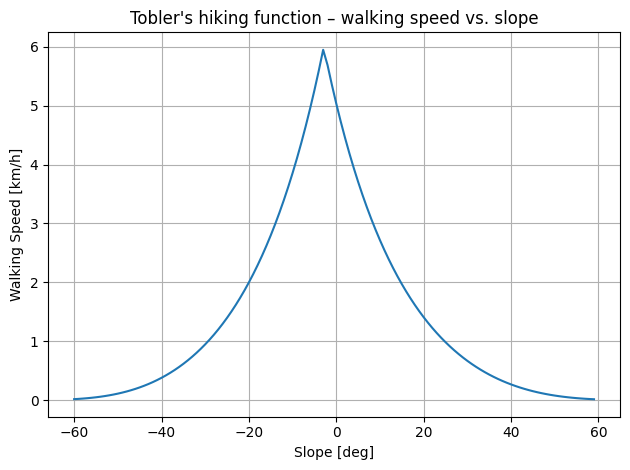

In [4]:
plot_data = []
degrees = range(-60, 60, 1)
for deg in degrees:
    plot_data.append([deg, 6*np.exp(-3.5*abs(np.tan(np.radians(deg))+0.05))])

plot_data = np.array(plot_data)

# Plot the tobler's hiking function
fig, ax = plt.subplots()
ax.set_title("Tobler's hiking function – walking speed vs. slope")
ax.set_ylabel('Walking Speed [km/h]')
ax.set_xlabel('Slope [deg]')
ax.grid()
ax.plot(plot_data[:, 0], plot_data[:, 1])
plt.tight_layout()

<b> Calculate the Slope in degrees </b>

In [5]:
# Scale
scale = 111120 if srs.IsGeographic() else 1.0

# Get the cellsize
cellsize_x = gt[1]
cellsize_y = -1 * gt[5]

cellsize_x = cellsize_x * 1.11e5 if srs.IsGeographic() else cellsize_x
cellsize_y = cellsize_y * 1.11e5 if srs.IsGeographic() else cellsize_y

# Calculate the slope
slope = gdal.DEMProcessing('', dem_src, 'slope', format='MEM', scale = scale)
slope_array = slope.ReadAsArray().astype(float)

# Calculate the hillshade (for visualization...)
hillshade = gdal.DEMProcessing('', dem_src, 'hillshade', format='MEM', scale = scale)
hillshade_array = hillshade.ReadAsArray().astype(float)

<b> Calculate the hiking function (walking speed) and the cost array (Travel time) </b>

In [6]:
# Calculate the walking speed
walking_speed = 6 * np.exp(-3.5 * abs(np.tan(np.radians(slope_array)) + 0.05))

# Cost: Travel time (seconds)
travel_time = (3600*cellsize_x/walking_speed/1000)

In [7]:
# Generate random positions
xi, yi = np.where(travel_time <=1)

# With num_gen = 6 you will generate 3 paths
num_gen = 6
indexes = np.random.randint(0, len(xi), num_gen)
random_pos = iter([[xi[i],yi[i]] for i in indexes])

<b> Calculate the least-cost paths using skimage route_through_array </b>

In [8]:
# Calculate the least-cost paths
result = []
for pos0, pos1 in zip(random_pos, random_pos):
    indices_i, cost_i = rta(travel_time, pos0, pos1, geometric=False, fully_connected=True)
    points_i = np.array(indices_i)  
    result.append([points_i, cost_i])

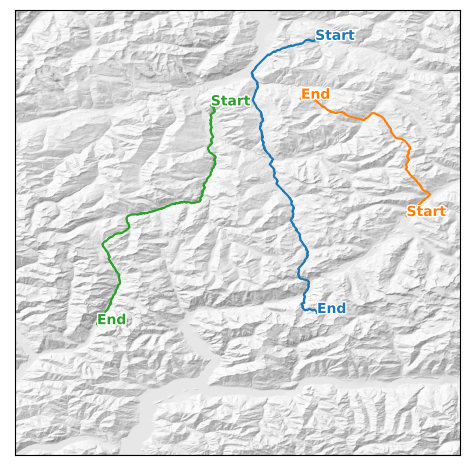

In [9]:
# Plot the result
fig, ax = plt.subplots()

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Plot the hillshade
ax.imshow(hillshade_array, cmap="Greys_r", alpha=0.5)

# Overlay the minimum-cost path
for points_i, cost_i in result:
    # Plot the path
    ax.plot(points_i[:, 1], points_i[:, 0])
    
    # Plot the start point
    ax.annotate("Start", (points_i[0][1], points_i[0][0]), 
                color=ax.get_lines()[-1].get_c(), weight='bold',
                path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    
    # Plot the end point
    ax.annotate("End", (points_i[-1][1], points_i[-1][0]), 
                color=ax.get_lines()[-1].get_c(), weight='bold',
                path_effects=[pe.withStroke(linewidth=2, foreground="white")])

plt.tight_layout()